In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def normalize(x):
    return (x -np.mean(x, axis=1, keepdims=True))/ (1e-8+np.std(x, axis=1, keepdims=True))

In [3]:
def run_dynamics(W, inputs,  dt=0.1, b=0.0):
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-dt) + dt*(np.matmul(acts, W))+dt*inputs
        preacts = normalize(preacts)
        acts = relu(preacts, b=b)
    return normalize(preacts), acts

In [4]:
def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

In [19]:
def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

In [ ]:
# The model with gaussian weights and learning rate = 10.0

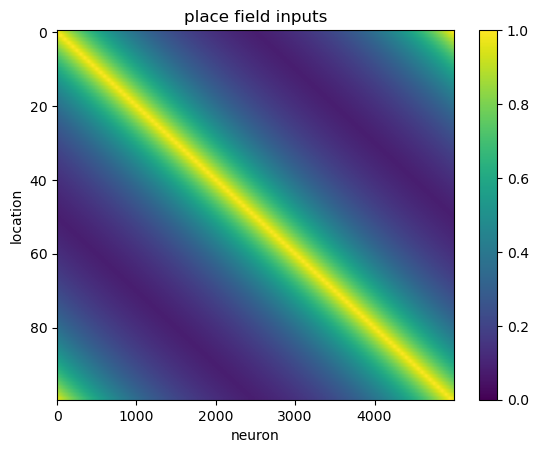

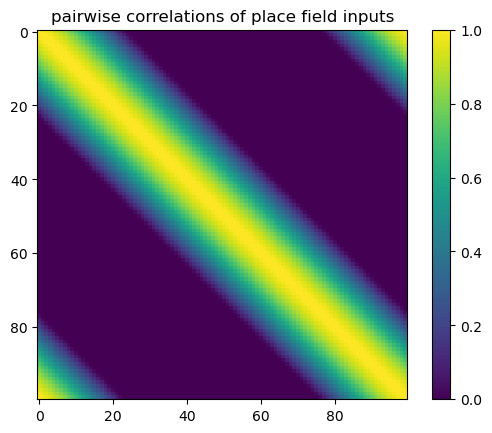

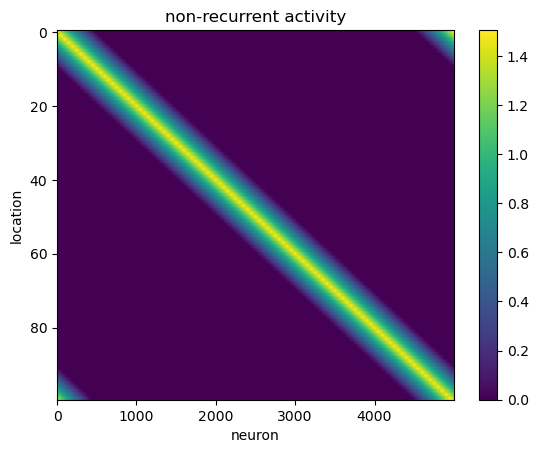

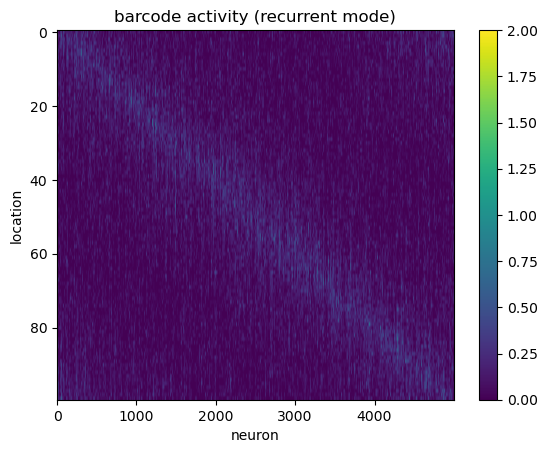

***
sparsity 0.15839


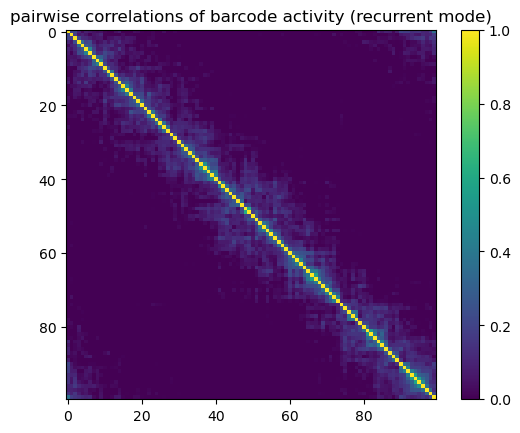

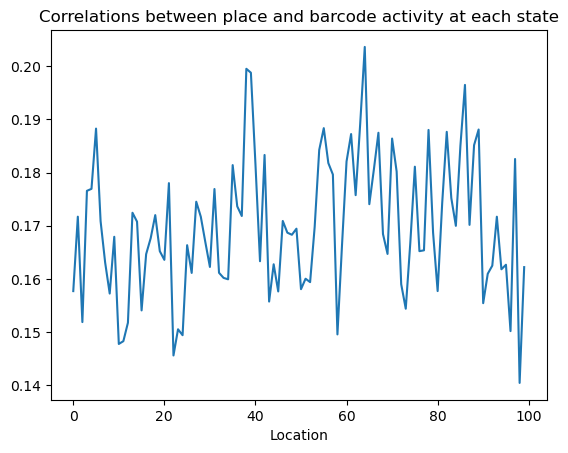

Now I just cached at location: 20


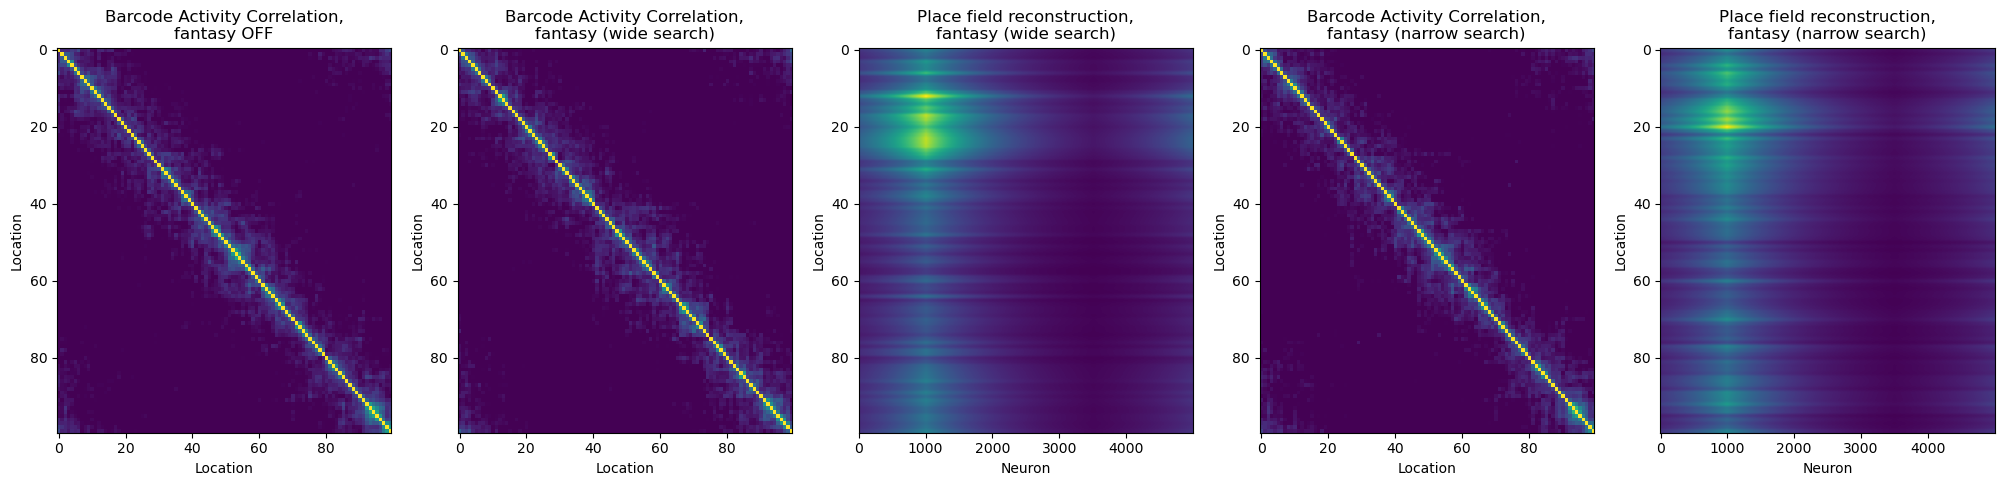

Now I just cached at location: 30


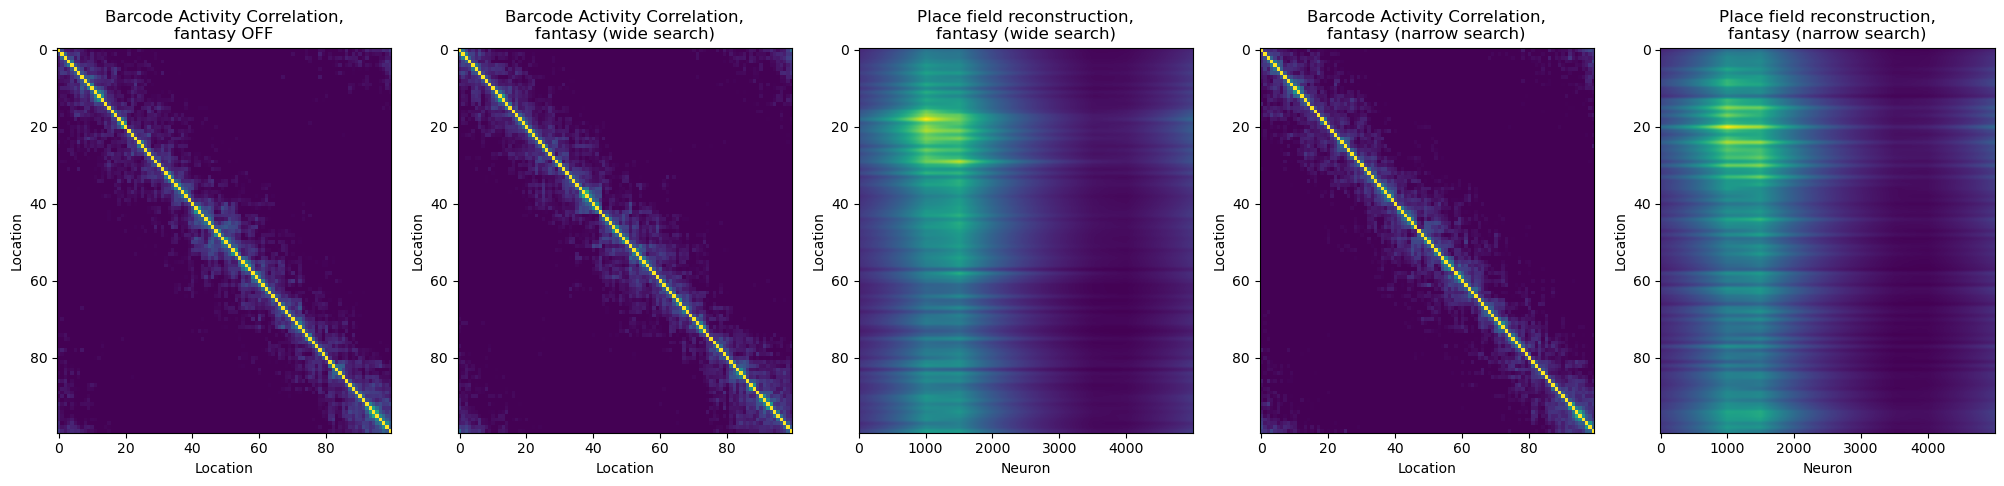

Now I just cached at location: 70


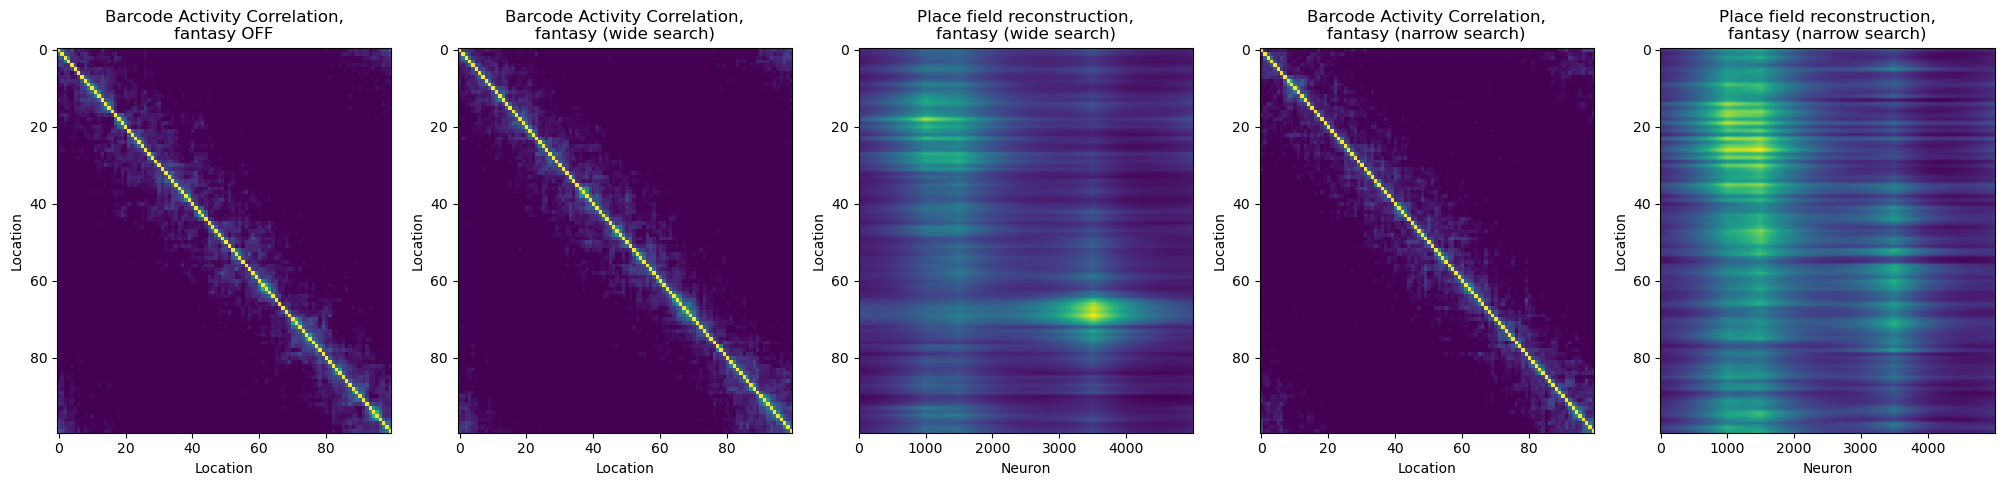

In [384]:
N_inp = 5000
N_bar = 5000

num_states = 100
decay_constant = 0.2
steps = 100
dt = 0.1
connection_sparsity = 0.01
num_connections = int(connection_sparsity*N_bar)

inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))

cache_states = [20, 30, 70]

input_strength = 1.0

W_reconstruct = np.zeros([N_inp, N_bar])

# SPARSE
# W_rec = np.zeros([N_bar, N_bar])
# for n in range(N_bar):
#     W_rec[np.random.choice(N_bar, size=(num_connections,)), n] = rec_strength/np.sqrt(num_connections)\
# plasticity_bias = -0.5
# lr = 3.0

# GAUSSIAN
rec_strength = 4.0 # INITIAL PARAMETER SWEEPS
plasticity_bias = -0.6 # INITIAL PARAMETER SWEEPS
lr = 10 # INITIAL PARAMETER SWEEPS

rand_J = np.random.randn(N_bar, N_bar)
W_rec = rec_strength*(rand_J / np.sqrt(N_bar))
b=1.0
W_fantasy = np.zeros([N_bar])

plt.imshow(inputs, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("place field inputs")
plt.show()


plt.imshow(pairwise_correlations_centered(inputs), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of place field inputs")
plt.show()

preacts, acts = run_dynamics(0*W_rec, input_strength*inputs, b=b)
nonrec_acts = acts
plt.imshow(acts, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("non-recurrent activity")
plt.show()

preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b)

plt.imshow(acts, vmin=0, vmax=2, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()

print('***')
print('sparsity', np.mean(acts>0))    
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of barcode activity (recurrent mode)")
plt.show()

acts_normalized = normalize(acts)
inputs_normalized = normalize(inputs)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

narrow_search_factor = 0.05
wide_search_factor = 0.2
for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b)
        
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), act) + np.matmul(np.ones_like(act.transpose())*plasticity_bias, act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b) 
    ax[0].set_title("Barcode Activity Correlation,\nfantasy OFF")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy, b=b) 
    ax[1].set_title("Barcode Activity Correlation,\nfantasy (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    ax[2].set_xlabel("Neuron")
    ax[2].set_ylabel("Location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction,\nfantasy (wide search)")
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, b=b) 
    ax[3].set_title("Barcode Activity Correlation,\nfantasy (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')
    

    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[4].set_xlabel("Neuron")
    ax[4].set_ylabel("Location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction,\nfantasy (narrow search)")
    
    for _ax in [ax[0], ax[1], ax[3]]:
        _ax.set_xlabel('Location')
        _ax.set_ylabel('Location')
        
    plt.show()

# Test 0: place fields unaffected (guaranteed to be true)

In [385]:
from sklearn.metrics import r2_score

In [386]:
from sklearn.preprocessing import minmax_scale

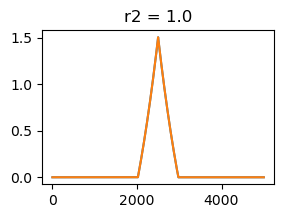

In [387]:
preacts, acts = run_dynamics(0.*W_rec, input_strength*inputs, b=b)
plt.figure(figsize=(3,2));
plt.plot(nonrec_acts[50])
plt.plot(acts[50])
sim = r2_score(nonrec_acts, acts)
plt.title(f'r2 = {sim}')
plt.show()

# Test 1: Likelihood of finding attractors

In [388]:
preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, b=b)
reconstruct = np.matmul(acts, W_reconstruct.transpose())

In [389]:
threshold_scale = 1.

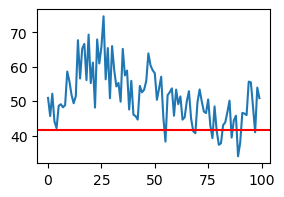

In [390]:
argmax_v = np.argmax(reconstruct, axis=1)
argmax_v = (argmax_v/N_inp)*num_states
max_v = np.max(reconstruct, axis=1)
threshold = reconstruct.mean()+0.5*reconstruct.std()

plt.figure(figsize=(3,2))
threshold = reconstruct.mean()+threshold_scale*reconstruct.std()
plt.plot(max_v)
plt.axhline(threshold, color='red')
plt.show()

attractor_dist = []
opt_attractor_dist = []
attractor_locs = []
attractor_validity = []
state_locs = []
for loc, _v in enumerate(argmax_v):
    if max_v[loc] < threshold:
        _v = -1
    _opt_dist = min([distance(loc, c, num_states) for c in cache_states])
    opt_attractor_dist.append(_opt_dist)
    state_locs.append(loc)
    if _v in cache_states:
        attractor_dist.append(distance(loc, _v, num_states))
        attractor_locs.append(_v)
        attractor_validity.append(1)
    else:
        attractor_dist.append(np.nan)
        attractor_locs.append(np.nan)
        attractor_validity.append(-1)
attractor_dist = np.array(attractor_dist)
attractor_locs = np.array(attractor_locs)
attractor_validity = np.array(attractor_validity)
opt_attractor_dist = np.array(opt_attractor_dist)
state_locs = np.array(state_locs)

In [391]:
# How many are snapped to an attractor?
valid = np.sum(attractor_validity==1)/attractor_validity.size
print(valid)

0.89


In [392]:
# How many of the states in between 20 and 30 are snapped to an attractor?
v = attractor_validity[np.logical_and(state_locs>20, state_locs<30)]
valid = np.sum(v==1)/v.size
print(valid)

1.0


# Test 2: Likelihood of finding close attractors

In [393]:
import pandas as pd
import seaborn as sns

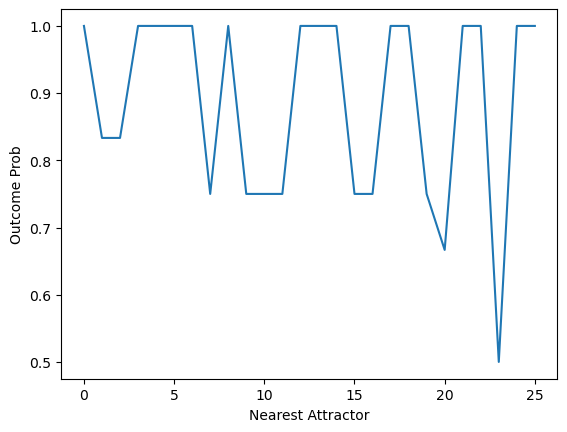

In [394]:
# How many are snapped to an attractor, as a function of nearest attractor?
xs = []; ys = []; labels = []
for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
    idxs = opt_attractor_dist==_opt_dist
    _validity = attractor_validity[idxs]
    valid = np.sum(_validity==1)/_validity.size
    xs.append(_opt_dist)
    ys.append(valid)
df = pd.DataFrame({'Nearest Attractor': xs, 'Outcome Prob': ys})
sns.lineplot(x='Nearest Attractor', y='Outcome Prob', data=df)
plt.show()

In [395]:
# Of those that snap to an attractor...
attractor_dist = attractor_dist[attractor_validity==1]
attractor_locs = attractor_locs[attractor_validity==1]
opt_attractor_dist = opt_attractor_dist[attractor_validity==1]

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_59856/1022643555.py:4: RuntimeWarning: invalid value encountered in divide
  sns.lineplot(x=opt_attractor_dist, y=attractor_dist/opt_attractor_dist)


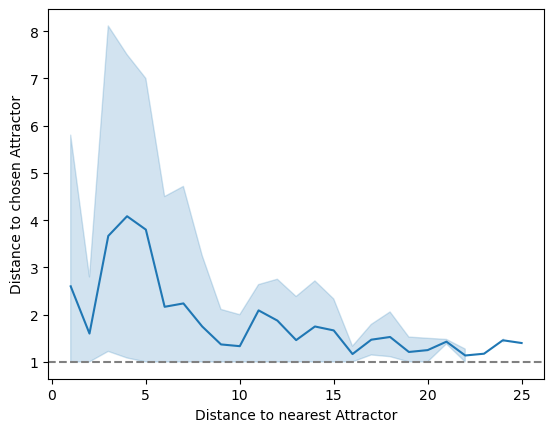

Cache 20: 0.24719101123595505
Cache 30: 0.6292134831460674
Cache 70: 0.12359550561797752


<Figure size 640x480 with 0 Axes>

In [396]:
# ... how far is the chosen attractor from the optimal?
plt.figure()
plt.axhline(1.0, linestyle='--', color='gray')
sns.lineplot(x=opt_attractor_dist, y=attractor_dist/opt_attractor_dist)
plt.xlabel('Distance to nearest Attractor')
plt.ylabel('Distance to chosen Attractor')
plt.show()

# ... which ones do they snap to?
plt.figure()
for idx, cache_state in enumerate(cache_states):
    p = np.sum(attractor_locs==cache_state)/attractor_locs.size
    print(f'Cache {cache_state}: {p}')

# Test 3: Barcode-barcode correlation

In [397]:
preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b)
c = pairwise_correlations_centered(acts)

In [398]:
data = {'Distance': [], 'Correlation': []}
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        data['Distance'].append(distance(i, j, num_states))
        data['Correlation'].append(c[i,j])
data = pd.DataFrame(data)

<AxesSubplot: xlabel='Distance', ylabel='Correlation'>

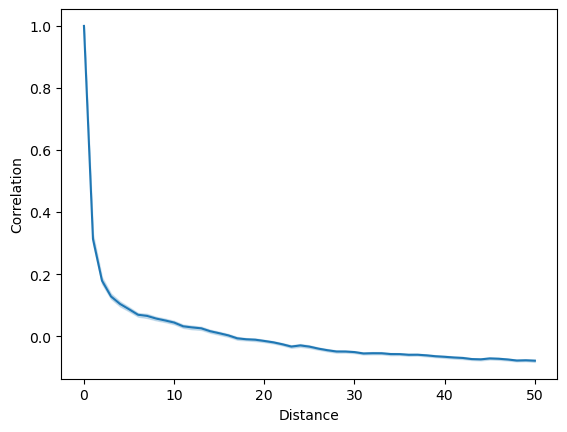

In [399]:
sns.lineplot(x='Distance', y='Correlation', data=data)

# Test 4: No relationship between place and barcode tuning

In [400]:
acts_normalized = normalize(acts)
inputs_normalized = normalize(inputs)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
print(np.mean(corrs))

0.16589496396384068
